# First model - Price Processing
Aims:

- Process time series bitcoin data into tensors, usable by ML model
- Use hourly data, sourced from Binance exchange
- Create and run a proof of concept simple LSTM model

Data:

- From: 2017-08-17 04-AM 
- To: 2021-02-03 00:00:00
- 33,022 rows in CSV
- May be some duplicate entries - 1266 days = 30,384 hrs (2k+ less)
- Columns: unix, date, symbol, open, high, low, close, Volume BTC, Volume USDT, tradecount

| Column      | Example             |
| ----------- | ------------------- |
| unix        | 1612310400000       |
| date        | 2021-02-03 00:00:00 |
| symbol      | BTC/USDT            |
| open        | 35472.71            |
| high        | 35618.75            |
| low         | 35362.38            |
| close       | 35476.99            |
| Volume BTC  | 518.474918          |
| Volume USDT | 18393856.0883226    |
| tradecount  | 10423               |

- There is an increase in precision of data and inclusion of `tradecount` from `2020-08-01 23:00:00` on-wards.<img src="img/0-1-change-precision-and-date.png" style="border: 1px solid white;" />
- There is also a duplication of data between `2020-08-01 23:00:00` and `2020-11-20 07:00:00`, with there being entries for each hour in both the lower precision previous format and the higher precision new format
  - row 1790 to 7087<img src="img/0-2-end-duplication.png" style="border: 1px solid white;" />

I can either filter out these duplications somehow, or use the consistent data between `2017-08-17 04-AM ` and `2020-08-01 11-PM`

I will need to filter out and remove these duplications in the future, but for today I want to ensure I get through basic processing and target creation along with training a first model. If I have time I will return to creating a pandas script to delete these duplications later today, but for now I will just use the data up to `2020-08-01 11-PM`.

The change in precision of columns: `open, high, low, close, Volume BTC, Volume USDT` should not matter too much for `open, high, low, close` the precision only added 0s, no extra precision.  `Volume BTC, Volume USDT` did increase in precision by 4dp and 6dp respectively (both from 2dp). I am not certain, but I do not believe this should affect things much. As a precaution the new data could be reduced to 2dp before vectorisation to keep consistency.

Below is a chart of the timeperiod from [barchart.com](https://www.barchart.com/crypto/quotes/%5EBTCUSD/interactive-chart)

![](img/0-3-barchart.png)

### Importning and inspecting the Data

Below we import the truncated dataset between `2017-08-17 04-AM ` and `2020-08-01 11-PM` and reverse it's order (as it is currently sorted from newest to oldes.)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np

current_folder = os.path.abspath('')
csv_file_path = os.path.join(current_folder, "Data", "Truncated_binance_1hr.csv")

# creating a pandas dataframe from CSV
df = pd.read_csv(csv_file_path)

# dataframe is sorted from newst to oldest, reverse order:
df = df[::-1]
df.shape

(25936, 10)

The truncated dataset contains 25936 rows (excluding column title row) and 10 features. Below we print out the first record as an example. The `tradecount` feauture is NaN for all entries, so will be dropped alongside the `unix, date, sumbol` columns as they are not relevant (the samples axis will provide the time information). We will also drop the `Volume USDT` column, as this is the same as `volume BTC` multiplied by the bitcoin price USD, so is probably redundant information.

In [2]:
df.iloc[0]

unix               1502942400.0
date           2017-08-17 04-AM
symbol                 BTC/USDT
open                   16199.91
high                   16199.91
low                     4261.32
close                   4308.83
Volume BTC                44.51
Volume USDT           190952.85
tradecount                  NaN
Name: 25935, dtype: object

Below we Plot the close price of each sample to confirm data was imported fine. As we can see this is a match to the graph sourced from charts.com.

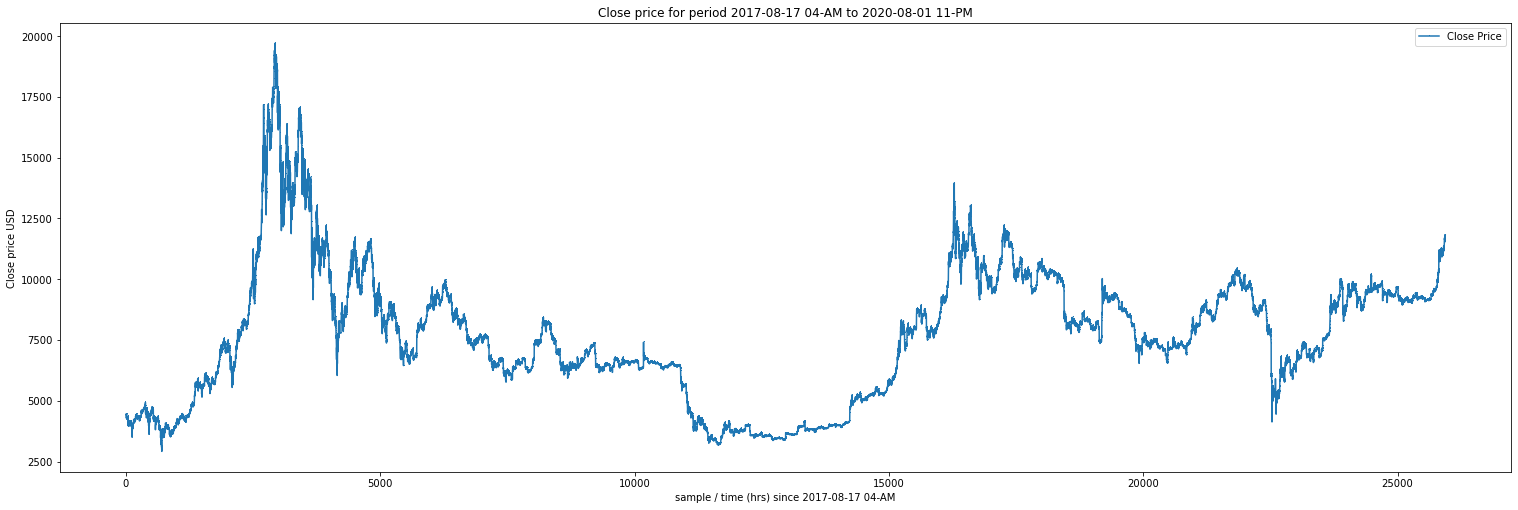

In [3]:
time_data = df["date"]
close_price = df["close"]
# setting witdth to 2x, so that figures can be side by side
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(22)
# plotting the training and validation loss
timesteps = range(1, len(time_data) + 1)
plt.plot(timesteps, close_price, '-,', label='Close Price')
plt.title("Close price for period 2017-08-17 04-AM to 2020-08-01 11-PM")
plt.xlabel('sample / time (hrs) since 2017-08-17 04-AM')
plt.ylabel('Close price USD')
plt.legend()
plt.tight_layout(pad=4.0)
plt.show()

### Processing the Data

Below we start processing the data by dropping the columns which won't be used/needed in the analysis.

In [4]:
# dropping volume USDT? seems like it equals [price * volumeBTC], probably redundant (could check after normalising data)
df = df.drop(columns=['unix', 'date', 'symbol', 'Volume USDT', 'tradecount'])
df.iloc[0]

open          16199.91
high          16199.91
low            4261.32
close          4308.83
Volume BTC       44.51
Name: 25935, dtype: float64

Below we set the size of the training, validation and test set, then change those values to the final indexes each set goes up to. In future we will keep these sets of variables with different names (as it complicated things later).

We then normalise the data based on the training set and print the first few entries of the normalised data.

In [5]:
training_samples = 12000
validation_samples = 7000
test_samples = len(df) - (training_samples + validation_samples)  #5936

#setting values to end sample for each
validation_samples += training_samples
test_samples += validation_samples
print(f"final sample - training: {training_samples}th, validation: {validation_samples}th, test: {test_samples}th")

# normalising data
mean = df[:training_samples].mean(axis=0)
df -= mean
std = df[:training_samples].std(axis=0)
df /= std

df.head()

final sample - training: 12000th, validation: 19000th, test: 25936th


,open,high,low,close,Volume BTC
25935,2.868773,2.804907,-1.093977,-1.080245,-1.008618
25934,-1.080411,-1.077008,-1.083815,-1.078089,-1.029751
25933,-1.078256,-1.071527,-1.077727,-1.075090,-1.045641
25932,-1.075257,-1.070043,-1.085154,-1.066574,-1.048411
25931,-1.066741,-1.060932,-1.069627,-1.063020,-1.051877


Below we seperate the raw data into training validation and test sets. We then individual create samples and targets, by aligning the data according to how far back each batch sample will consider (lookback), how far ahead the predicted target is (delay) and how many steps between individual samples to include in batches (steps).

In [6]:
train_data = df[:training_samples]
val_data = df[training_samples:validation_samples]
test_data = df[validation_samples:]

lookback = 120 # 5 days, 24*5                       #past
step = 1    # no step initially                     #
delay = 24  # try make predictions 1 day from now   #future
batch_size = 128                                    #

In [7]:
# Setting up the training data
start = lookback + delay
end = start + training_samples

x_train = pd.DataFrame(train_data).to_numpy()
y_train = df.iloc[start:end, 3]
y_train = pd.DataFrame(y_train).to_numpy()

#setting up the validation data
start = end 
end = start + 7000      #TODO: fix this mess

x_val = pd.DataFrame(val_data).to_numpy()
y_val = df.iloc[start:end, 3]
y_val = pd.DataFrame(y_val).to_numpy()

# setting up test data
start = end
end = len(df)
print(start)
print(end)

x_test = pd.DataFrame(test_data).to_numpy()
x_test = x_test[:-(lookback + delay)]
y_test = df.iloc[start:end, 3]
y_test = pd.DataFrame(y_test).to_numpy()

# setting the sequence length - relevant when
sequence_length = int(lookback / step) # in case change the step later

# testing that the final target in the test set corresponds to the final close value in the dataframe
print(y_test[6791])
print(df.iloc[25935])

19144
25936
[1.40829417]
open          1.401959
high          1.372866
low           1.432459
close         1.408294
Volume BTC    1.126612
Name: 0, dtype: float64


We then use the keras `preprocessing.timeseries_dataset_from_array()` method to create datasets from our indicidual samples. The samples are collected into small sequences (lookback long) with a final target, for feeding into the timeseries model. These sequences are equivalent to individual samples in normal ML tasks. (This method works in a similar way to a generator)

In [8]:
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

### The Model

Before defining the model, we check the shape of the resulting datasets for feeding into our GRU model.

In [9]:
for batch in train_dataset.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (128, 120, 5)
Target shape: (128, 1)


We have defined a very simple GRU model using `mae` as a metric for this initial test. Below we train the model for 20 epochs and plot the results.

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = models.Sequential()
model.add(layers.GRU(32, input_shape=(inputs.shape[1], inputs.shape[2])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
93/93 [==============================] - 18s 194ms/step - loss: 0.1921 - val_loss: 0.1005
Epoch 2/20
93/93 [==============================] - 17s 183ms/step - loss: 0.1253 - val_loss: 0.0935
Epoch 3/20
93/93 [==============================] - 17s 179ms/step - loss: 0.1189 - val_loss: 0.0896
Epoch 4/20
93/93 [==============================] - 18s 188ms/step - loss: 0.1145 - val_loss: 0.0850
Epoch 5/20
93/93 [==============================] - 16s 175ms/step - loss: 0.1111 - val_loss: 0.0839
Epoch 6/20
93/93 [==============================] - 17s 185ms/step - loss: 0.1098 - val_loss: 0.0817
Epoch 7/20
93/93 [==============================] - 16s 177ms/step - loss: 0.1093 - val_loss: 0.0808
Epoch 8/20
93/93 [==============================] - 17s 186ms/step - loss: 0.1086 - val_loss: 0.0800
Epoch 9/20
93/93 [==============================] - 17s 179ms/step - loss: 0.1080 - val_loss: 0.0806
Epoch 10/20
93/93 [==============================] - 17s 185ms/step - loss: 0.1078 - val_lo

In [11]:
def plot_graphs(title):
    # setting witdth to 2x, so that figures can be side by side
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(11)
    
    # plotting the training and validation loss
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']

    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss:  ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout(pad=4.0)
    plt.show()

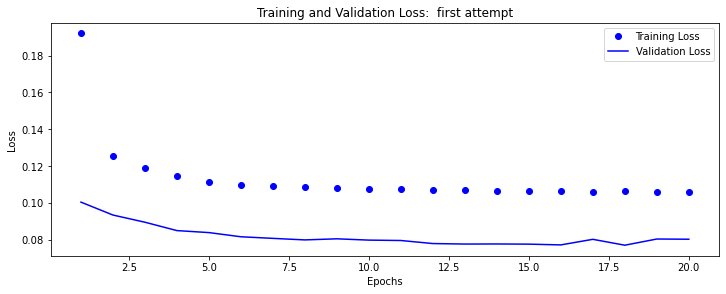

In [12]:
plot_graphs("first attempt")

### Results

From the plot, there seems to be minimal overfitting, there may be some gains to be made by expanding the network, however those experiments will be done in the following weeks. The results seem ok and it seems our data-processing has worked (though we will double check this as well soon).

Below we will run this model on the test set then translate the loss from MAE to USD by multiplying with the standard deviation.

In [13]:
result = model.evaluate(test_dataset)

53/53 [==============================] - 5s 88ms/step - loss: 0.0776


In [15]:
print(result * std[3])

233.6568634353225


So a final MAE loss of `0.0776` which translates to an error of $233.66.

We currently don't have any way of telling if this is a good or bad result, in later weeks we will build a commonsense baseline as well as methods of comparing models. However $234 doesn't seem too bad for predictions 24rs in the future fconsidering the range and volatility of the prices in the graph. We will need to double check, but it suggests that the bassic model is working and finding useful representations of the data.

### Conclusion

We achieved what we set out to do, we will double check, but the data-processing seems to have worked. We will convert many of the processes in this sheet into helper functions in the future. We will also work on cleaning the duplicates we encountered in the CSV so that we can use the full dataset in future.

But for now, we have a good proof of concept and a foundation to work off!